In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
geemap.ee_initialize()

In [3]:
m = geemap.Map(center=[20,0],zoom=2)

In [4]:
def geometry_geoJson(file_path):
    with open(file_path) as f:
        json_data = json.load(f)
    moi = geemap.geojson_to_ee(json_data)
    return moi

def inland_water_extent(startDate, endDate, roi, filename):
    # Constants
    WATER_THRESHOLD = 0.25


    images = ee.ImageCollection("COPERNICUS/S2").filterDate(startDate,endDate).filterBounds(roi)
    nd_images = images.map(lambda img: img.normalizedDifference(["B3", "B11"]).copyProperties(img,['system:time_start']))
    result_images = nd_images.map(lambda img: img.gt(0.25).copyProperties(img,['system:time_start']))

    m.centerObject(roi,9)
    m.addLayer(result_images.mean().clip(roi),{'min':0,'max':1,'palette':['white','blue']},"Water Body")


    def cal_area(img):
      pixel_area = img.multiply(ee.Image.pixelArea())
      m2 = pixel_area.reduceRegion(
          **{
              "geometry": roi,
              "reducer": ee.Reducer.sum(),
              "scale": 30,
              "bestEffort": True,
          }
      ).get('nd')
      km2 = ee.Number(m2).divide(1e6)
      date = img.date().format('YYYY-MM-dd')

      return img.set({"km2": km2, "m2": m2, 'Date': date})

    areas = result_images.map(cal_area)
    data_list = areas.getInfo()['features']

     
    area_list = []
    for f in data_list:
        props = f['properties']
        area_list.append({
            'm2': props['m2'],
            'km2': props['km2'],
            'Date': props['Date']
        })

    df = pd.DataFrame(area_list, index=[x for x in range(1, len(area_list) + 1)])

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Display DataFrame
    print(df.head(10))
    print('\n')

    # Save DataFrame to CSV
    df.to_csv(f"{filename}.csv")

    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['km2'], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Area (km²)')
    plt.title('Surface Water Extent Time Series')
    plt.grid(True)
    plt.show()

    # Save Plot
    plt.savefig(f"{filename}.jpg")
    plt.show()

              m2         km2       Date
1   7.586221e+06    7.586221 2018-01-02
2   1.881442e+08  188.144189 2018-01-02
3   1.011589e+05    0.101159 2018-01-02
4   8.048493e+06    8.048493 2018-01-07
5   1.815803e+08  181.580317 2018-01-07
6   8.487204e+04    0.084872 2018-01-07
7   7.526836e+06    7.526836 2018-01-17
8   1.587200e+08  158.720044 2018-01-17
9   4.200353e+04    0.042004 2018-01-17
10  6.897392e+06    6.897392 2018-01-22




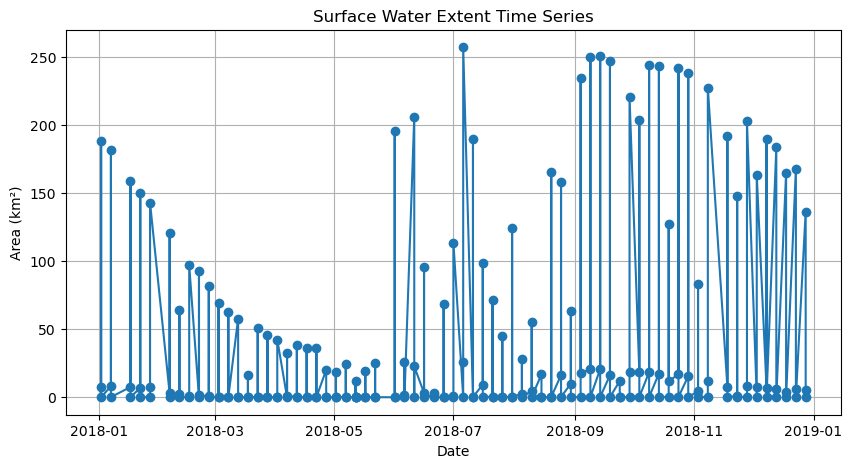

<Figure size 640x480 with 0 Axes>

In [5]:
# Date range from 2018-01-01 - 2019-01-01
roi = geometry_geoJson("C:\\Users\\ibnha\\Documents\\TungabhadraReservoir.geojson")

inland_water_extent('2018-01-01','2019-01-01',roi,"TungabhadraReservoir")

In [6]:
m

Map(center=[15.199544156353635, 76.19590699014441], controls=(WidgetControl(options=['position', 'transparent_…